# Imports

In [1]:
import math

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [4]:
device = 'cuda'

# The dataset

In [5]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd().rsplit("/",  1)[0]+'/data/'+dataset_name+'.csv')

In [6]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

In [60]:
train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

In [61]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

 State-gov 9
 Bachelors 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 United-States 42
 <=50K 2
Set 3


In [62]:
train.head()

,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,Set
0,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0,1
1,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0,1
2,53,4,234721,1,7,2,6,0,2,1,0,0,40,39,0,1
3,28,4,338409,9,13,2,10,5,2,0,0,0,40,5,0,1
4,37,4,284582,12,14,2,4,5,4,0,0,0,40,39,0,1


In [63]:
categorical_columns.remove('Set')
categorical_columns.remove(' <=50K')

In [64]:
all_columns = train.columns

In [65]:
cont_columns = [s for s in all_columns if s not in categorical_columns]

In [66]:
cont_columns.remove('Set')
cont_columns.remove(' <=50K')

In [72]:
target_column = ' <=50K'

In [68]:
cont_columns, categorical_columns, target_column

(['39', ' 77516', ' 13', ' 2174', ' 0', ' 40'],
 [' State-gov',
  ' Bachelors',
  ' Never-married',
  ' Adm-clerical',
  ' Not-in-family',
  ' White',
  ' Male',
  ' United-States'],
 [' <=50K'])

In [69]:
features = cont_columns + categorical_columns

In [70]:
len_cat_cols = len(categorical_columns)
len_cont_cols = len(cont_columns)
cat_emb_dim=[2, 2, 3, 2, 2, 3, 2, 2]
len(cat_emb_dim), len_cat_cols, len_cont_cols

(8, 8, 6)

In [73]:
cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [74]:
cat_dims

[9, 16, 7, 15, 6, 5, 2, 42]

In [91]:
n_classes = len(np.unique(train[target].values))

In [75]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [76]:
ds_train = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train))
ds_valid = TensorDataset(torch.tensor(X_valid).float(), torch.tensor(y_valid))

In [77]:
dl_train = DataLoader(ds_train, batch_size=128, shuffle=True, num_workers=4)
dl_valid = DataLoader(ds_valid, batch_size=128, shuffle=False, num_workers=4)

# Sparsemax

In [78]:
from torch import nn
from torch.autograd import Function
import torch.nn.functional as F

import torch

"""
Other possible implementations:
https://github.com/KrisKorrel/sparsemax-pytorch/blob/master/sparsemax.py
https://github.com/msobroza/SparsemaxPytorch/blob/master/mnist/sparsemax.py
https://github.com/vene/sparse-structured-attention/blob/master/pytorch/torchsparseattn/sparsemax.py
"""


# credits to Yandex https://github.com/Qwicen/node/blob/master/lib/nn_utils.py
def _make_ix_like(input, dim=0):
    d = input.size(dim)
    rho = torch.arange(1, d + 1, device=input.device, dtype=input.dtype)
    view = [1] * input.dim()
    view[0] = -1
    return rho.view(view).transpose(0, dim)


class SparsemaxFunction(Function):
    """
    An implementation of sparsemax (Martins & Astudillo, 2016). See
    :cite:`DBLP:journals/corr/MartinsA16` for detailed description.
    By Ben Peters and Vlad Niculae
    """

    @staticmethod
    def forward(ctx, input, dim=-1):
        """sparsemax: normalizing sparse transform (a la softmax)
        Parameters:
            input (Tensor): any shape
            dim: dimension along which to apply sparsemax
        Returns:
            output (Tensor): same shape as input
        """
        ctx.dim = dim
        max_val, _ = input.max(dim=dim, keepdim=True)
        input -= max_val  # same numerical stability trick as for softmax
        tau, supp_size = SparsemaxFunction._threshold_and_support(input, dim=dim)
        output = torch.clamp(input - tau, min=0)
        ctx.save_for_backward(supp_size, output)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        supp_size, output = ctx.saved_tensors
        dim = ctx.dim
        grad_input = grad_output.clone()
        grad_input[output == 0] = 0

        v_hat = grad_input.sum(dim=dim) / supp_size.to(output.dtype).squeeze()
        v_hat = v_hat.unsqueeze(dim)
        grad_input = torch.where(output != 0, grad_input - v_hat, grad_input)
        return grad_input, None

    @staticmethod
    def _threshold_and_support(input, dim=-1):
        """Sparsemax building block: compute the threshold
        Args:
            input: any dimension
            dim: dimension along which to apply the sparsemax
        Returns:
            the threshold value
        """

        input_srt, _ = torch.sort(input, descending=True, dim=dim)
        input_cumsum = input_srt.cumsum(dim) - 1
        rhos = _make_ix_like(input, dim)
        support = rhos * input_srt > input_cumsum

        support_size = support.sum(dim=dim).unsqueeze(dim)
        tau = input_cumsum.gather(dim, support_size - 1)
        tau /= support_size.to(input.dtype)
        return tau, support_size


sparsemax = SparsemaxFunction.apply


class Sparsemax(nn.Module):

    def __init__(self, dim=-1):
        self.dim = dim
        super(Sparsemax, self).__init__()

    def forward(self, input):
        return sparsemax(input, self.dim)

# The  Model

In [79]:
class GLU(nn.Module):

    def __init__(self, units):
        super().__init__()
        self.units = units

    def forward(self, x):

        return x[:, :self.units] * torch.sigmoid(x[:, self.units:])

In [80]:
class FeatureTransformer(nn.Module):

    def __init__(self, in_features, out_features, bn_momentum, previous_transformer=None):
        super().__init__()
        self.block1 = self.block(in_features, out_features, bn_momentum)
        self.block2 = self.block(out_features, out_features, bn_momentum)
        self.previous_transformer = previous_transformer

    def block(self, in_features, out_features, bn_momentum):
        return nn.Sequential(
            nn.Linear(in_features, out_features * 2, bias=False),
            nn.BatchNorm1d(out_features * 2, momentum=bn_momentum),
            GLU(out_features)
        )

    def forward(self, x):
        if self.previous_transformer is not None:
            x = self.previous_transformer(x)

        o1 = self.block1(x)

        if self.previous_transformer is not None:
            o1 = (o1 + x) * math.sqrt(0.5)

        o2 = self.block2(o1)
        return (o2 + o1) * math.sqrt(0.5)

In [81]:
class AttentiveTransformer(nn.Module):

    def __init__(self, comp_size, n_features, relaxation_factor, epsilon):
        super().__init__()
        self.relaxation_factor = relaxation_factor
        self.epsilon = epsilon

        self.dense = nn.Linear(comp_size, n_features)
        self.bn = nn.BatchNorm1d(n_features)
        self.sparsemax = Sparsemax()

    def forward(self, features_for_coef, complemantary_aggregated_mask_values):
        mask_values = self.dense(features_for_coef)
        mask_values = self.bn(mask_values)
        mask_values =  mask_values * complemantary_aggregated_mask_values
        mask_values = self.sparsemax(mask_values)

        complemantary_aggregated_mask_values = complemantary_aggregated_mask_values * (
            self.relaxation_factor - mask_values)
        entropy = torch.sum(-mask_values *
                            torch.log(mask_values + self.epsilon), dim=1)
        entropy = entropy.mean()
        return mask_values, complemantary_aggregated_mask_values, entropy

In [98]:
class TabNet(nn.Module):

    def __init__(self, n_features, hidden_size, output_dim, decision_steps=2,
                 relaxation_factor=1, epsilon=1e-4, bn_momentum=0.7):
        super().__init__()

        self.hidden_size = hidden_size
        self.output_dim = output_dim
        self.n_features = n_features
        self.decision_steps = decision_steps
        self.bn_momentum = bn_momentum

        self.bn = nn.BatchNorm1d(n_features, momentum=self.bn_momentum)

        # feature transformer shared accross steps
        self.shared_transformer = FeatureTransformer(n_features, hidden_size, self.bn_momentum)

        # step dependent feature transformer
        self.step_transformers = nn.ModuleList([
            FeatureTransformer(hidden_size, hidden_size, self.bn_momentum,
                               self.shared_transformer)
            for _ in range(decision_steps)
        ])

        self.attentive_transformers = nn.ModuleList([
            AttentiveTransformer(
                self.hidden_size-self.output_dim, self.n_features, relaxation_factor, epsilon)
            for _ in range(decision_steps - 1)
        ])

    def forward(self, x, output_masks=False):
        x = self.bn(x)  # applies batch norm on the input
        batch_size = x.shape[0]
        output_aggregated = torch.zeros(batch_size, self.output_dim).to(device)
        mask_values = torch.zeros(batch_size, self.n_features).to(device)
        aggregated_mask_values = torch.zeros(
            batch_size, self.n_features).to(device)
        complemantary_aggregated_mask_values = torch.ones(
            batch_size, self.n_features).to(device)
        total_entropy = 0

        mask_values_per_step = []

        masked_features = x

        for i, step_transformer in enumerate(self.step_transformers):

            o = step_transformer(masked_features)

            if i > 0:
                decision_out = F.relu(o[:, :self.output_dim])
                output_aggregated = output_aggregated + decision_out

                # for visualization
                scale_agg = torch.sum(
                    decision_out, dim=1, keepdim=True) / (self.decision_steps - 1)
                aggregated_mask_values = aggregated_mask_values + mask_values * scale_agg

            features_for_coef = o[:, self.output_dim:]

            if i < self.decision_steps - 1:
                attentive_transformer = self.attentive_transformers[i]
                mask_values, complemantary_aggregated_mask_values, entropy = attentive_transformer(
                    features_for_coef, complemantary_aggregated_mask_values)
                total_entropy = total_entropy + \
                    entropy / (self.decision_steps - 1)

                masked_features = mask_values * x

                if output_masks:
                    mask_values_per_step.append(mask_values.detach().cpu())

        outputs = (output_aggregated, total_entropy)
        if output_masks:
            outputs = outputs + (aggregated_mask_values, mask_values_per_step)

        return outputs

In [128]:
class TabNetClassifier(TabNet):
    
    def __init__(self, output_dim, n_classes, n_cont_feats, cat_dims, cat_emb_dims, **tabnet_kwargs):
        
        self.n_cont_feats = n_cont_feats
        self.total_cat_feats = sum(cat_emb_dims)
        self.total_feats = n_cont_feats + self.total_cat_feats
        
        super().__init__(output_dim=output_dim,n_features=self.total_feats, **tabnet_kwargs)
        
        assert len(cat_dims) == len(cat_emb_dims)
                

        
        self.embs = nn.ModuleList([
            nn.Embedding(nc, ne) for nc, ne in zip(cat_dims, cat_emb_dims)
        ])
        
        self.classifier = nn.Linear(output_dim, n_classes, bias=False)
    
    def forward(self, x, output_masks=False):
        x_cont = x[:,:self.n_cont_feats]
        x_cat = torch.empty(x.shape[0], self.total_cat_feats).to(x.device)
        
        start = 0
        for i, emb in enumerate(self.embs):
            xi = x[:, i + self.n_cont_feats].long()
            xemb = emb(xi)            
            end = start + xemb.shape[1]
            x_cat[:, start:end] = xemb
            start = end
            
        x = torch.cat((x_cont, x_cat), dim=1)
        
        outputs = super().forward(x, output_masks)
        logits = self.classifier(outputs[0])
        outputs = (logits,) + outputs
        return outputs

In [194]:
out_features = 16
output_dim = 8

In [193]:
128 * 8

1024

In [210]:
# tabnet = TabNet(in_features, out_features, output_dim, decision_steps=4)
model = TabNetClassifier(output_dim, n_classes,
                        n_cont_feats=len_cont_cols,
                        cat_dims=cat_dims,
                        cat_emb_dims=cat_emb_dim,
                        hidden_size=out_features,
                        relaxation_factor=1.0,
                        bn_momentum=0.1,
                        epsilon=1e-15,
                        decision_steps=4)

In [211]:
device = 'cuda'

In [212]:
model.to(device)

TabNetClassifier(
  (bn): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (shared_transformer): FeatureTransformer(
    (block1): Sequential(
      (0): Linear(in_features=24, out_features=32, bias=False)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GLU()
    )
    (block2): Sequential(
      (0): Linear(in_features=16, out_features=32, bias=False)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GLU()
    )
  )
  (step_transformers): ModuleList(
    (0): FeatureTransformer(
      (block1): Sequential(
        (0): Linear(in_features=16, out_features=32, bias=False)
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GLU()
      )
      (block2): Sequential(
        (0): Linear(in_features=16, out_features=32, bias=False)
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, tra

In [213]:
x, y = next(iter(dl_train))

In [134]:
with torch.no_grad():
    out = model(x.float().to(device))

In [135]:
len(out)

3

# Training

In [214]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),  lr=2e-2)

In [215]:
for _ in range(60):
    model.train()
    model.zero_grad()
    for i, (x, y) in enumerate(dl_train):
        
        
        out = model(x.float().to(device))
        loss = loss_fn(out[0], y.long().to(device))
        loss.backward()
        
        if i % 1 == 0:
            optimizer.step()
            model.zero_grad()
        
        
    model.eval()
    loss_valid = 0
    preds = []
    trues = []
    
    for x, y in dl_valid:
        with torch.no_grad():
            out = model(x.float().to(device))
            loss_valid += loss_fn(out[0], y.long().to(device)).item()
            
        preds += out[0].argmax(-1).cpu().numpy().tolist()
        trues += y.cpu().numpy().tolist()
    
    preds = np.array(preds)
    trues = np.array(trues)
    print(loss_valid/len(dl_valid), (1.* (preds==trues)).mean())

0.41090923089247483 0.7867122011797578
0.41443082575614637 0.77708786091276
0.41110552847385406 0.7705681465383422
0.3624224548156445 0.8314188140329091
0.3923909274431375 0.776156473144986
0.39738955520666563 0.7643588947531822


KeyboardInterrupt: 

In [153]:
(out[0].argmax(-1).cpu() == y.long()).float().mean()

tensor(0.8750)

In [154]:
logits, out_agg, _, agg_mask, mask_per_step = model(x.float().to(device), True)

In [155]:
out_agg.max(), out_agg.min()

(tensor(13.3430, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(0., device='cuda:0', grad_fn=<MinBackward1>))

In [156]:
agg_mask.shape, agg_mask.max(), agg_mask.min()

(torch.Size([128, 24]),
 tensor(28.1767, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(0., device='cuda:0', grad_fn=<MinBackward1>))

In [157]:
mask_per_step[2].shape

torch.Size([128, 24])

In [158]:
agg_mask = agg_mask.detach().cpu().numpy()

In [159]:
agg_mask_norm = (agg_mask - agg_mask.min(0)) / (agg_mask.max(0) - agg_mask.min(0))

In [166]:
len(mask_per_step), mask_per_step[0].shape

(3, torch.Size([128, 24]))

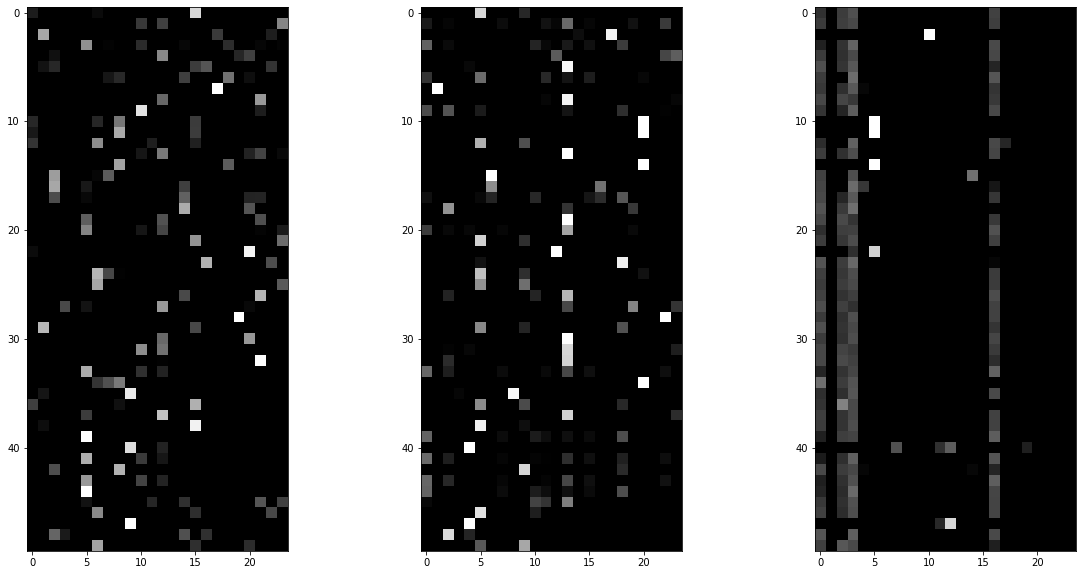

In [176]:
fig, axs = plt.subplots(ncols=len(mask_per_step), figsize=(20,10))
for m, ax in zip(mask_per_step, axs):
    ax.imshow(m[:50], cmap='gray')

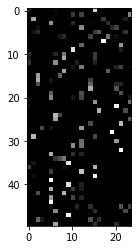

In [171]:
plt.imshow(mask_per_step[0][:50], cmap='gray')

In [161]:
sum(mask_per_step)

tensor([[0.3061, 0.0000, 0.2359,  ..., 0.0000, 0.0000, 0.0000],
        [0.3257, 0.0000, 0.2672,  ..., 0.0000, 0.2272, 0.5230],
        [0.0000, 0.6525, 0.0000,  ..., 0.0000, 0.1199, 0.0000],
        ...,
        [0.9931, 0.0000, 0.4860,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.6868, 0.0000, 0.1048,  ..., 0.0000, 0.0000, 0.0000]])

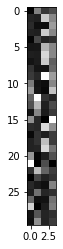

In [502]:
plt.imshow(agg_mask_norm, cmap='gray')